<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/data_cleaning/merge_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten Zusammenführen - Veraltet

## Import der benötigten Module und allgemeines Setup:

In [ ]:
## import modules
import os, sys

import numpy as np
import pandas as pd
import matplotlib

import seaborn as sns
from matplotlib import pyplot as plt

from datetime import datetime
from datetime import timedelta

In [ ]:
# Verbinden mit der Google-Drive herstellen
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standort der Messstation
latitude = 50.2
longitude = 7.8

# Kennwerte um den richtigen Zeitstempel zu berechnen
seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [ ]:
# Pfad und Dateinamen zu den Dataframes auf der Google-Drive

# UVI-Index Messwerte
name_Messwerte = 'UVI_Messdaten.csv'
# Globalstrahlungsmesswerte
name_Solar_Messwerte = 'Solys_Messdaten.csv'
# CAMS Meteorologische Vorhersagedaten
name_Vorhersage = 'Vorhersage.csv'
# CAMS Globalstrahlungsvorhersage
name_GlobalVorhersage = 'solar_radiation_forecast.csv'

# Angabe der benötigten Dateipfade
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
GLO_drive_path = '/content/drive/My Drive/Colab_Notebooks/CSV_SolarRadiation/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

## Einlesen der Globalstrahlungsdaten, UVI-Daten und CAMS-Vorhersagedaten:

In [ ]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_Solys = pd.read_csv(drive_path + name_Solar_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)
df_GLO_CAMS = pd.read_csv(GLO_drive_path + name_GlobalVorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_Solys.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)
df_GLO_CAMS.set_index('Observation_period', inplace=True)

# Index in Datetime umwandeln
df_UVI.index = pd.to_datetime(df_UVI.index)
df_Solys.index = pd.to_datetime(df_Solys.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)
df_GLO_CAMS.index = pd.to_datetime(df_GLO_CAMS.index)

### In der CAMS-Globalstrahlungvorhersage die Nullwerte löschen

In [ ]:
def plot_datetime_timelines(dfs, labels=None, colors=None, save_path=None):
    """
    Plottet die Zeitpunkte der DatetimeIndex von vier DataFrames auf einem gemeinsamen Zeitstrahl.

    Parameters:
    dfs (list): Liste von vier pandas DataFrames mit einem DatetimeIndex.
    labels (list, optional): Liste von Labels für jeden DataFrame.
    colors (list, optional): Liste von Farben für jede Zeitreihe.

    Returns:
    None
    """
    if labels is None:
        labels = [f"DF{i+1}" for i in range(len(dfs))]
    if colors is None:
        colors = ['blue', 'orange', 'green', 'red']

    plt.figure(figsize=(12, 4))
    for i, df in enumerate(dfs):
        datetimes = df.index
        y_vals = [i + 1] * len(datetimes)
        plt.scatter(datetimes, y_vals, marker='|', s=200, color=colors[i], label=labels[i])

    plt.yticks(range(1, len(dfs) + 1), labels)
    plt.xlabel('Zeit')
    plt.title('Zeitstrahl der vorhandenen Daten')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot gespeichert unter: {save_path}")

    plt.show()



Plot gespeichert unter: /content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/


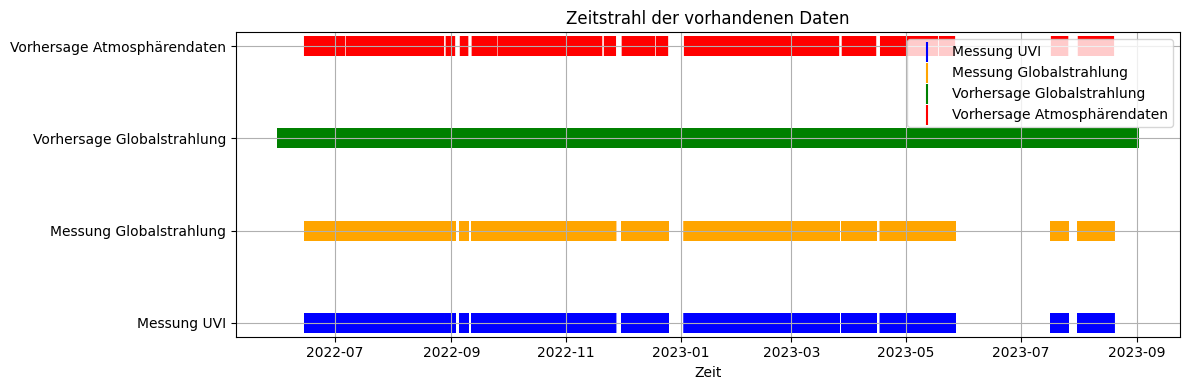

In [ ]:
plot_datetime_timelines([df_UVI, df_Solys, df_GLO_CAMS, df_CAMS],
                        labels=["Messung UVI", "Messung Globalstrahlung", "Vorhersage Globalstrahlung", "Vorhersage Atmosphärendaten"], save_path = output_plot_path)

In [ ]:
# NaN Einträge durch 0 ersetzen
df_UVI['UVI'] = df_UVI['UVI'].fillna(0)
df_UVI['erythem'] = df_UVI['erythem'].fillna(0)
df_Solys.dropna(inplace = True)

In [ ]:
# In df_GLO_CMAS ersetzen aller 0 Einträge durch nan
df_GLO_CAMS.replace(0, np.nan, inplace=True)
# Entfernen aller Zeilen mit NaN-Werten
df_GLO_CAMS.dropna(inplace=True)
# Prüfen, ob in dem Datraframe Nullwerte enthalten sind
df_GLO_CAMS.isnull().sum()

,0
Clear_sky_GHI,0
Clear_sky_BHI,0
GHI,0
BHI,0


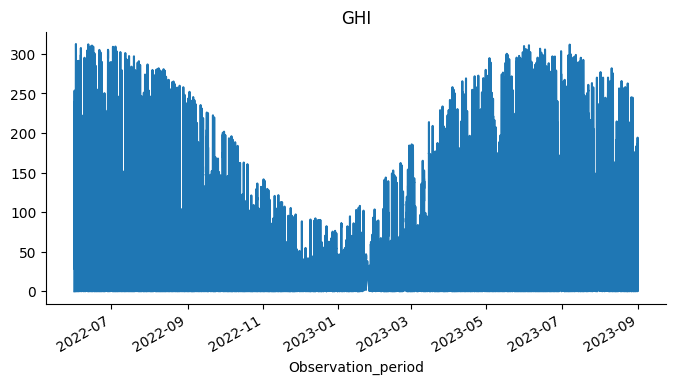

In [ ]:
# Plotten der GHI-Werte über das Jahr
df_GLO_CAMS['GHI'].plot(kind='line', figsize=(8, 4), title='GHI')
plt.gca().spines[['top', 'right']].set_visible(False)

## Löschen von nicht gebrauchten Zeilen:

Die Datensätze Solys GHI, UVI, CAMS Vorhersage und CAMS Globalstrahlung haben alle unterschiedlich viele Einträgen. Die Solys-Daten besitzen die wenigsten Einträge. Deshalb werden alle anderen Datensätze an die Einträge in die Solys-Daten angepasst.

In [ ]:
def keep_common_rows(df_a, df_b):
    # Sicherstellen, dass beide DataFrames einen DateTime-Index haben
    df_a.index = pd.to_datetime(df_a.index)
    df_b.index = pd.to_datetime(df_b.index)

    # Finden der gemeinsamen Zeitpunkte unter Berücksichtigung der Minute-Verschiebung
    common_index = df_a.index.isin(df_b.index) # df_a.index.shift(-pd.Timedelta(minutes=1)).isin(df_b.index)

    # Filtern von DataFrame A basierend auf den gefundenen gemeinsamen Zeitpunkten
    df_a_filtered = df_a[common_index]

    return df_a_filtered

In [ ]:
# Reduzieren der CAMS-Globalstrahlungsvorhersagedaten
df_GLO_CAMS = keep_common_rows(df_GLO_CAMS, df_Solys)

In [ ]:
df_GLO_CAMS

,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI
Observation_period,,,,
2022-06-15 07:21:00,188.748,154.357,188.748,154.3570
2022-06-15 07:23:00,190.480,155.933,190.480,155.9330
2022-06-15 07:25:00,192.206,157.504,192.206,157.5040
2022-06-15 07:27:00,193.924,159.068,193.924,159.0680
2022-06-15 07:29:00,195.635,160.627,195.635,160.6270
...,...,...,...,...
2023-03-22 12:19:00,213.539,171.420,77.163,0.0839
2023-03-22 12:21:00,213.134,171.004,76.276,0.0764
2023-03-22 12:23:00,212.708,170.571,75.385,0.0689


In [ ]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)
    dataframe.reset_index(inplace=True)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

In [ ]:
df_file_name = 'solar_radiation_forecast.csv'
# save_dataframe_to_drive(df_GLO_CAMS, '/content/drive/My Drive/Colab_Notebooks/Clean_Data', df_file_name)